# Samuel Chiang USCID: 7187956023

## Time Series Classification
An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, roc_curve, auc


from sklearn.feature_selection import RFECV 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
column = []
features = ['min', 'max', 'mean', 'median', 'std', '1stquart', '3rdquart']
column = [feature+str(i) for i in range(1,7) for feature in features]

feature_df = pd.DataFrame(columns=column+['activity', 'file_index'])
feature_df

,min1,max1,mean1,median1,std1,1stquart1,3rdquart1,min2,max2,mean2,...,3rdquart5,min6,max6,mean6,median6,std6,1stquart6,3rdquart6,activity,file_index


In [3]:
files_dict = {'bending1':7, 'bending2':6, 'cycling':15, 'lying':15, 'sitting':15, 'standing':15, 'walking':15}
data_dict = {}

i=0
for dir_name,value in list(files_dict.items()):
    for j in range(1, value + 1):
        file = 'AReM/%s/dataset%d.csv'%(dir_name, j)
        if file == 'AReM/bending2/dataset4.csv':
            df = pd.read_csv(file, sep=' ', skiprows = 5, names = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13',\
                                                                   'var_rss13', 'avg_rss23', 'var_rss23'], \
                                                                     usecols=range(7))
        else:
            df = pd.read_csv(file, sep=',', skiprows = 4, usecols=range(7))
            
        if 'bending' in dir_name:
            df['activity'] = 'bending'
        else:
            df['activity'] = 'other'

        if dir_name not in data_dict:
            data_dict[dir_name] = [df]
        else:
            data_dict[dir_name].append(df)
        
        instance = []

        for column in range(1,7):
            minimum = df.iloc[:,column].to_frame().min()[0]
            maximum = df.iloc[:,column].to_frame().max()[0]
            mean = df.iloc[:,column].to_frame().mean()[0]
            median = df.iloc[:,column].to_frame().median()[0]
            std = df.iloc[:,column].to_frame().std()[0]
            quartile1 = df.iloc[:,column].to_frame().quantile(.25, axis = 0)[0]
            quartile3 = df.iloc[:,column].to_frame().quantile(.75, axis = 0)[0]
            instance.extend((minimum, maximum, mean, median, std, quartile1, quartile3))
        instance.append(dir_name)
        instance.append(j)
        feature_df.loc[i] = instance   
        i += 1

In [4]:
train_full_data = data_dict['bending1'][2:files_dict['bending1']] + data_dict['bending2'][2:files_dict['bending2']]\
        + data_dict['cycling'][3:files_dict['cycling']] + data_dict['lying'][3:files_dict['lying']] + data_dict['sitting'][3:files_dict['sitting']]\
        + data_dict['standing'][3:files_dict['standing']] + data_dict['walking'][3:files_dict['walking']]
test_full_data = data_dict['bending1'][0:2] + data_dict['bending2'][0:2] + data_dict['cycling'][0:3] + \
       data_dict['lying'][0:3] + data_dict['sitting'][0:3] + data_dict['standing'][0:3] + \
       data_dict['walking'][0:3]
test = feature_df.loc[(feature_df.activity.str.contains('bending')) & (feature_df.file_index.isin([1,2]))]
#train
train = feature_df.loc[(feature_df.activity.str.contains('bending')) & (~feature_df.file_index.isin([1,2]))]
#test 
test=pd.concat([test,feature_df.loc[(~feature_df.activity.str.contains('bending')) & (feature_df.file_index.isin([1,2,3]))]])
#train
train = pd.concat([train,feature_df.loc[(~feature_df.activity.str.contains('bending')) & (~feature_df.file_index.isin([1,2,3]))]])
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True) 
test

,min1,max1,mean1,median1,std1,1stquart1,3rdquart1,min2,max2,mean2,...,3rdquart5,min6,max6,mean6,median6,std6,1stquart6,3rdquart6,activity,file_index
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1,1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372437,...,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1,2
2,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2,1
3,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2,2
4,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,2.374208,...,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,cycling,1
5,28.75,44.75,37.561187,36.875,3.226507,35.2500,40.2500,0.0,9.91,2.080687,...,21.5000,0.0,9.62,2.765896,2.450,1.769203,1.4100,3.770,cycling,2
6,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,...,21.0000,0.0,8.55,2.983750,2.570,1.815730,1.5000,4.150,cycling,3
7,23.50,30.00,27.716375,27.500,1.442253,27.0000,29.0000,0.0,1.79,0.363687,...,10.7500,0.0,4.50,0.734271,0.710,0.613688,0.4300,1.000,lying,1
8,24.75,48.33,44.182937,48.000,7.495615,48.0000,48.0000,0.0,3.11,0.101875,...,5.5425,0.0,3.91,0.692771,0.500,0.675781,0.3225,0.940,lying,2
9,48.00,48.25,48.004167,48.000,0.032038,48.0000,48.0000,0.0,0.43,0.007167,...,10.0000,0.0,2.50,0.641229,0.500,0.388372,0.4600,0.830,lying,3


In [5]:
trainx=train.drop(columns=["activity","file_index"])
trainy=train.loc[:,'activity'].values
testx=test.drop(columns=["activity","file_index"])
testy=test.loc[:,'activity'].values

In [6]:
def feature_length_extract(data, length, preprocess=False):
    data_dict = {}
    loc = 0
    #print(length)
    for data_point in data:
        instance = []
        dmy_data=data_point
        if preprocess:
            dmy_data['activity']=[1 if i=='bending' else 0 for i in data_point['activity']]
            min_max_scaler = preprocessing.MinMaxScaler()
            scaledvalues = min_max_scaler.fit_transform(dmy_data.values)
            dmy_data = pd.DataFrame(scaledvalues)
            dmy_data.columns = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23','activity']
        row = int(dmy_data.shape[0] / length)
        for i in range(0,length):
            temp_df = dmy_data.iloc[i*row: (i+1)*row]              
            for column in range(1,7):
                minimum = temp_df.iloc[:,column].to_frame().min()[0]
                maximum = temp_df.iloc[:,column].to_frame().max()[0]
                mean = temp_df.iloc[:,column].to_frame().mean()[0]
                median = temp_df.iloc[:,column].to_frame().median()[0]
                std = temp_df.iloc[:,column].to_frame().std()[0]
                quartile1 = temp_df.iloc[:,column].to_frame().quantile(.25, axis = 0)[0]
                quartile3 = temp_df.iloc[:,column].to_frame().quantile(.75, axis = 0)[0]
                instance.extend((minimum, maximum, mean, median, std, quartile1, quartile3))
        data_dict[loc] = instance
        loc +=1
    return data_dict

### (c) Feature Extraction
Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

#### Simple statistical features
Means in each of the 𝑑 dimensions<br>
Standard deviations of the 𝑑 dimensions<br>
Skewness, Kurtosis and Higher order moments of the 𝑑 dimensions<br>
Maximum and Minimum values<br><br>

Reference: [https://stats.stackexchange.com/questions/50807/features-for-time-series-classification](https://stats.stackexchange.com/questions/50807/features-for-time-series-classification)

### ii. Extract the time-domain features minimum, maximum, mean, median, stan- dard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [7]:
feature_df.drop(columns=["activity","file_index"])

,min1,max1,mean1,median1,std1,1stquart1,3rdquart1,min2,max2,mean2,...,std5,1stquart5,3rdquart5,min6,max6,mean6,median6,std6,1stquart6,3rdquart6
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,2.188449,33.0000,36.0000,0.00,1.92,0.570583,0.430,0.582915,0.0000,1.3000
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372437,...,1.995255,32.0000,34.5000,0.00,3.11,0.571083,0.430,0.601010,0.0000,1.3000
2,35.00,47.40,43.954500,44.330,1.558835,43.0000,45.0000,0.0,1.70,0.426250,...,1.999604,35.3625,36.5000,0.00,1.79,0.493292,0.430,0.513506,0.0000,0.9400
3,33.00,47.75,42.179812,43.500,3.670666,39.1500,45.0000,0.0,3.00,0.696042,...,3.849448,30.4575,36.3300,0.00,2.18,0.613521,0.500,0.524317,0.0000,1.0000
4,33.00,45.75,41.678063,41.750,2.243490,41.3300,42.7500,0.0,2.83,0.535979,...,2.411026,28.4575,31.2500,0.00,1.79,0.383292,0.430,0.389164,0.0000,0.5000
5,37.00,48.00,43.454958,43.250,1.386098,42.5000,45.0000,0.0,1.58,0.378083,...,2.488862,22.2500,24.0000,0.00,5.26,0.679646,0.500,0.622534,0.4300,0.8700
6,36.25,48.00,43.969125,44.500,1.618364,43.3100,44.6700,0.0,1.50,0.413125,...,3.318301,20.5000,23.7500,0.00,2.96,0.555312,0.490,0.487826,0.0000,0.8300
7,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,3.693786,20.5000,27.0000,0.00,4.97,0.700188,0.500,0.693720,0.4300,0.8700
8,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,5.053642,15.0000,20.7500,0.00,6.76,1.122125,0.830,1.012342,0.4700,1.3000
9,21.00,50.00,32.586208,33.000,6.238143,26.1875,34.5000,0.0,9.90,0.516125,...,5.032424,17.6700,23.5000,0.00,13.61,1.162042,0.830,1.332980,0.4700,1.3000


In [8]:
trainx.describe().loc['std']

min1         8.794295
max1         4.429182
mean1        4.917717
median1      4.956111
std1         1.758629
1stquart1    5.731262
3rdquart1    4.783645
min2         0.000000
max2         5.147841
mean2        1.600661
median2      1.436903
std2         0.902769
1stquart2    0.952201
3rdquart2    2.158258
min3         3.053869
max3         4.759853
mean3        3.863304
median3      3.845730
std3         0.996008
1stquart3    4.145255
3rdquart3    3.946023
min4         0.000000
max4         2.302408
mean4        1.179781
median4      1.149585
std4         0.473525
1stquart4    0.842771
3rdquart4    1.566564
min5         5.368786
max5         5.449726
mean5        5.120513
median5      5.267414
std5         1.057973
1stquart5    5.543882
3rdquart5    4.957231
min6         0.051766
max6         2.540166
mean6        1.171306
median6      1.104626
std6         0.519377
1stquart6    0.774233
3rdquart6    1.550218
Name: std, dtype: float64

### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [9]:
bootestimate = pd.DataFrame(columns = list(feature_df.columns))
for i in range(1000):
    boot = resample(trainx, replace=True, n_samples=trainx.shape[0])
    bootestimate = bootestimate.append(boot.apply(np.std, ddof=1, axis = 0), ignore_index=True) #series into dataframe
interval = bootestimate.apply(np.percentile, args=([5,95],), axis = 0)
ci = pd.Series([(interval.loc[0,col], interval.loc[1,col]) for col in list(trainx.columns)], index=list(trainx.columns))
ci

/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


min1          (7.543067917943148, 10.069726544953143)
max1           (3.3160450915526334, 5.37005867873461)
mean1          (4.335812242243502, 5.439448014552852)
median1        (4.339408310629314, 5.508418633447977)
std1         (1.5516575566475326, 1.9561884741195357)
1stquart1      (5.145882522119486, 6.229069241878332)
3rdquart1     (3.9196030562238615, 5.529510978100015)
min2                                       (0.0, 0.0)
max2           (4.64056438933877, 5.5195217376483585)
mean2         (1.4098724331771753, 1.737634526093837)
median2      (1.2501962425765694, 1.5704479950783419)
std2         (0.8111525706077387, 0.9628369019910601)
1stquart2    (0.8263503058325332, 1.0401143563774216)
3rdquart2    (1.9062054276206943, 2.3327887854812954)
min3         (2.8245214912497882, 3.2144117598966884)
max3           (3.964993696072259, 5.366753508398779)
mean3         (3.1625155314474758, 4.394814748056549)
median3       (3.1187412129472647, 4.413370726809838)
std3         (0.779709213632

### iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

#### min, mean and max

## (d) Binary Classification Using Logistic Regression

### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


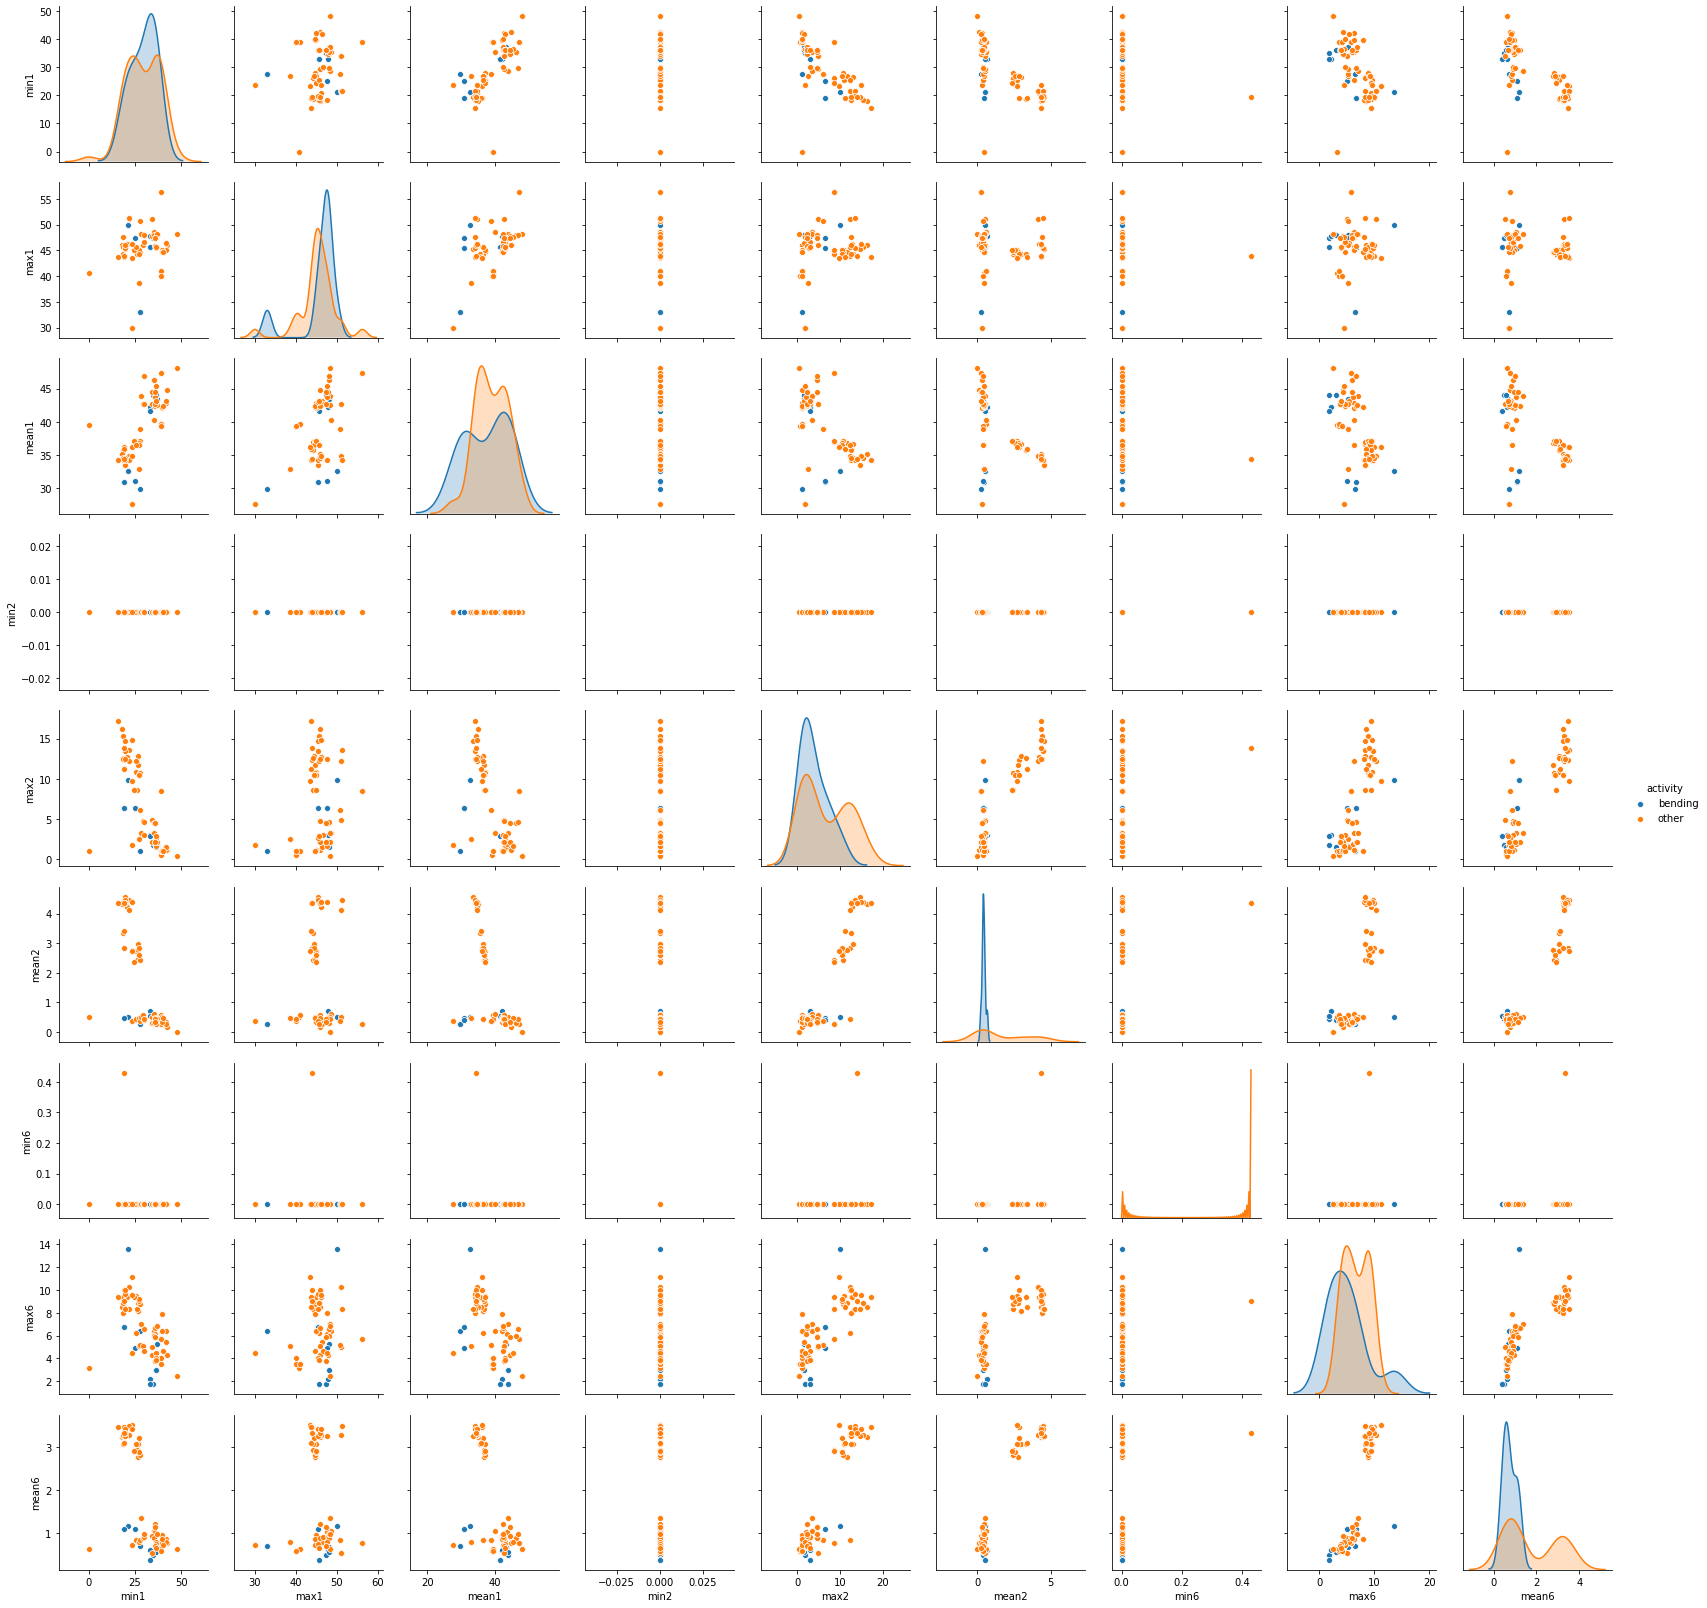

In [10]:
train_tmp=train
train_tmp['activity'] = np.where(train_tmp.activity.str.contains('bending'), 'bending', 'other')
sns.pairplot(train_tmp.loc[:, ['min1', 'max1', 'mean1', 'min2', 'max2', 'mean2','min6', 'max6', 'mean6','activity']]\
             , hue = "activity")

### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?

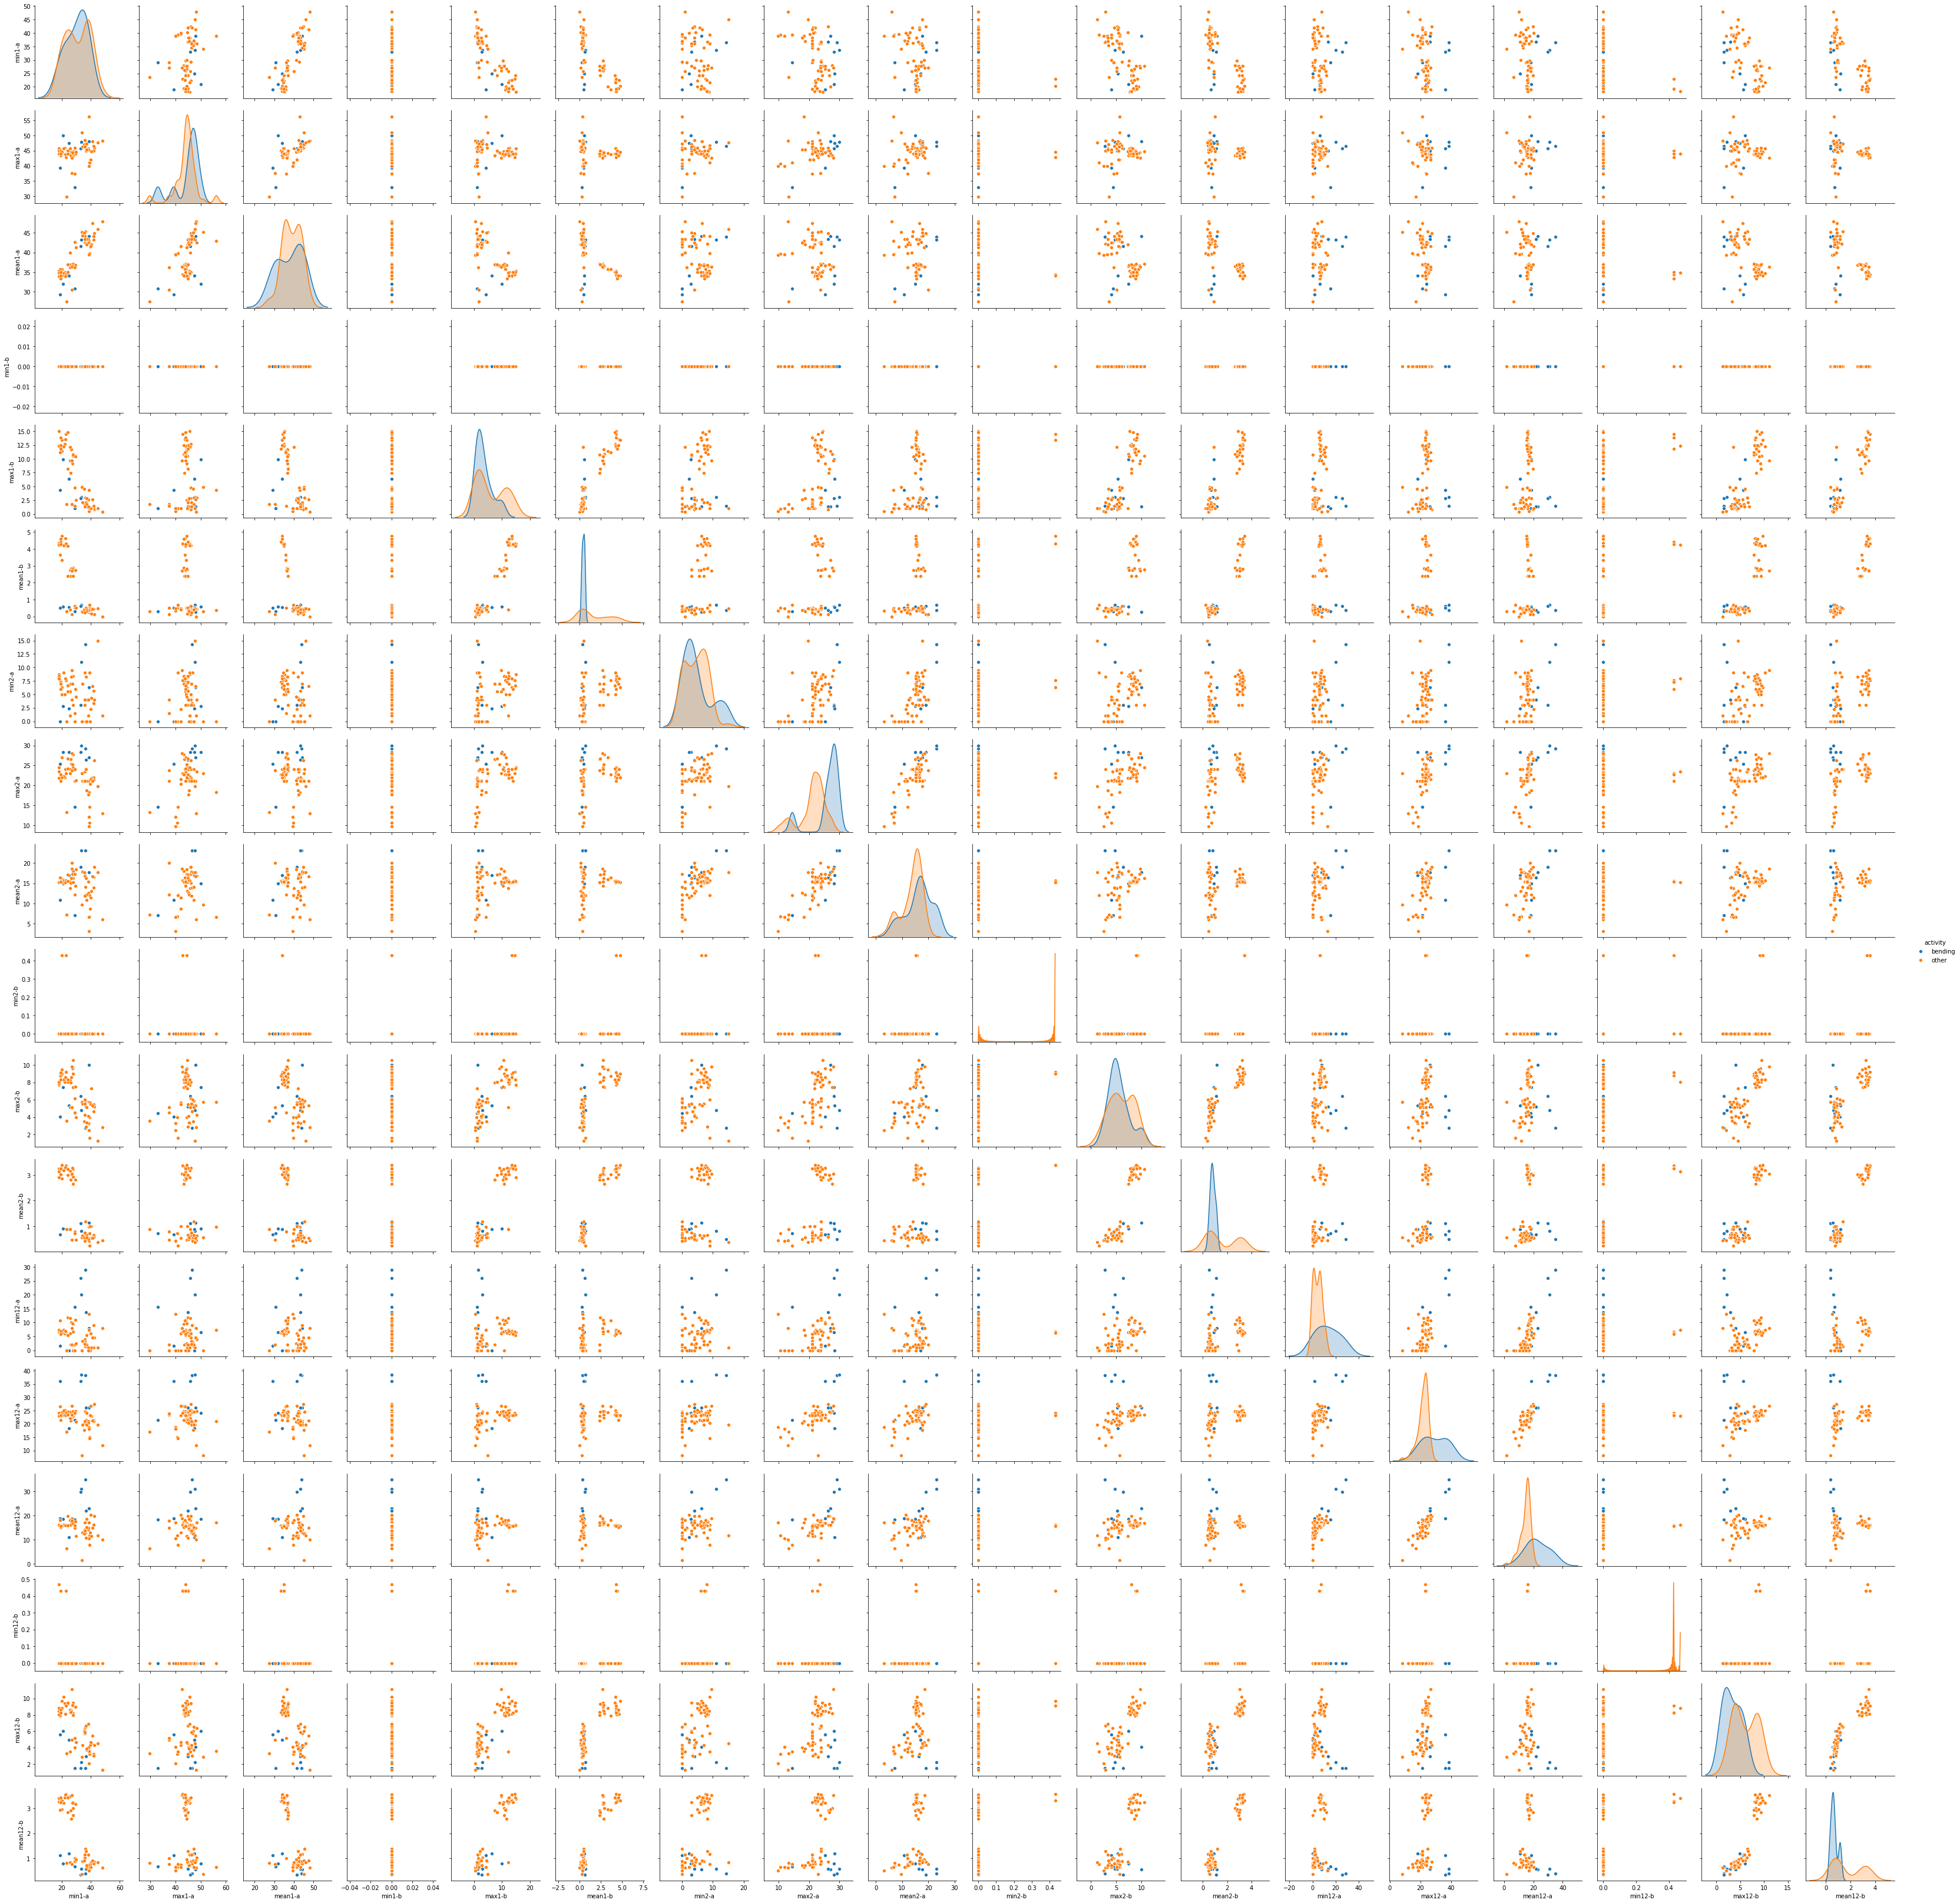

In [11]:
train_dict = {}
loc = 0

for data_point in train_full_data:
    instance = []
    row = int(data_point.shape[0] / 2)
    for i in range(0,2):
        temp_df = data_point.iloc[i*row: (i+1)*row]              
        for column in range(1,7):
            minimum = temp_df.iloc[:,column].to_frame().min()[0]
            maximum = temp_df.iloc[:,column].to_frame().max()[0]
            mean = temp_df.iloc[:,column].to_frame().mean()[0]
            instance.extend((minimum, maximum, mean))
    train_dict[loc] = instance
    loc +=1
train_df = pd.DataFrame.from_dict(train_dict, orient='index')
train_df['activity'] = ['bending' if i < 10 else 'other' for i in range(1, 70)] 
train_df = train_df.iloc[:,pd.np.r_[0:12,30:37]]
train_df.columns = ['min1-a', 'max1-a','mean1-a', 'min1-b', 'max1-b','mean1-b','min2-a', 'max2-a','mean2-a','min2-b',\
                   'max2-b','mean2-b', 'min12-a', 'max12-a','mean12-a', 'min12-b', 'max12-b','mean12-b', 'activity']
train_df
sns.pairplot(train_df, hue = "activity")

### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features.

<p> The correct way to do Cross Validation is to make feature selection a part of the training model. The selected features would use the training data, which provides a more accurate test error since there is no relationship between the predictors and the outcome. <br>The wrong way is to select predictors using all the data, then only use cross validation when training and testing. It ignores the fact that the procedure has already seen the labels of the training data, and made use of them. The predictors would be selected for their correlation with the outcome.

Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole data set. It seeks to ensure that each fold has the same ratio of each class as the original data set. Stratification is generally a better scheme, both in terms of bias and variance, when compared to regular cross-validation. <p>

##### Resources: [https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation](https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)

In [12]:
score_df = pd.DataFrame(columns=['Time Serious Number', 'Features', \
                                     'Cross Validation Score'])

for length in range(1,21):
    train_dict = feature_length_extract(train_full_data, length)
    train_df = pd.DataFrame.from_dict(train_dict, orient='index')
    train_df['activity'] = [1 if i < 10 else 0 for i in range(1, 70)]
    x_train = train_df.iloc[:,:-1]
    y_train = train_df[['activity']]
    lr = LogisticRegression()
    rfecv = RFECV(estimator = lr, cv = StratifiedKFold(5))
    rfecv.fit(x_train, y_train.values.ravel())
    score_df.loc[length-1] = [length, rfecv.n_features_, max(rfecv.grid_scores_)] 
    
score_df

,Time Serious Number,Features,Cross Validation Score
0,1.0,4.0,0.985714
1,2.0,4.0,0.985714
2,3.0,4.0,1.000000
3,4.0,5.0,0.985714
4,5.0,19.0,0.985714
5,6.0,5.0,0.971429
6,7.0,33.0,0.985714
7,8.0,4.0,0.985714
8,9.0,45.0,0.985714
9,10.0,13.0,0.971429


<p>Based on our time serious score data set, we can retrieve the best cross validation score from the time serious length of 3. length=3 and uses 4 features to achieve the cross validation score of 1.000000. </p>

### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data.


The confusion matrix is: 
[[60  0]
 [ 0  9]]

The ROC curve for l = 1 is as follows, and the AUC = 1.000000


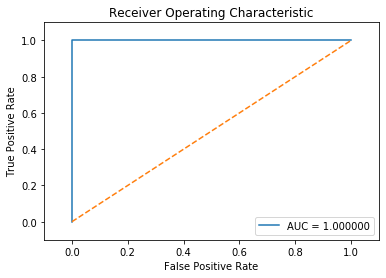

                 Generalized Linear Model Regression Results                  
Dep. Variable:               activity   No. Observations:                   69
Model:                            GLM   Df Residuals:                       64
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:               -0.43435
Date:                Mon, 24 Jun 2019   Deviance:                      0.86870
Time:                        19:58:04   Pearson chi2:                    0.442
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3768      8.606      0.044      0.965     -16.490      17.244
Q(28)          0.4269      0.356      1.199      0.2

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [13]:
length=3
train_dict = feature_length_extract(train_full_data, length)
train_df = pd.DataFrame.from_dict(train_dict, orient='index')
train_df['activity'] = [1 if i < 10 else 0 for i in range(1, 70)]

x_train = train_df.iloc[:,:-1]
y_train = train_df[['activity']]
lr = LogisticRegression()
rfecv = RFECV(estimator = lr, cv = StratifiedKFold(5))
rfecv.fit(x_train, y_train.values.ravel())

attr_index = []

for i, value in enumerate(rfecv.support_):
    if value == True:
        attr_index.append(i)
        
x_train_tmp = x_train.iloc[:,attr_index]
model = lr.fit(x_train_tmp, y_train.values.ravel())
y_pred = model.predict(x_train_tmp)

print('\nThe confusion matrix is: ')
print(confusion_matrix(y_train, y_pred))

fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr,tpr)
print("\nThe ROC curve for l = 1 is as follows, and the AUC = %f"% auc(fpr,tpr))
plt.figure()
plt.plot(fpr, tpr, label='AUC = %f' % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1],  linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

train_df = x_train_tmp
train_df.loc[:,'activity'] = y_train['activity']
formula = 'activity ~ Q(28) + Q(34) + Q(48) + Q(120)'

glm_logit = smf.glm(formula = formula, data=train_df, family=sm.families.Binomial(sm.families.links.logit))
model = glm_logit.fit(maxiter=5)
print(model.summary())

### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

<p> When running the test data set on the model created from length=3, we can get a 1.00000 cross-validation accuracy on our test set.</p>

In [14]:
length=3
test_dict = feature_length_extract(test_full_data, length)
test_df = pd.DataFrame.from_dict(test_dict, orient='index')
test_df['activity'] = [1 if i < 5 else 0 for i in range(1, 20)]

x_test = test_df.iloc[:,:-1]
y_test = test_df[['activity']]
x_test_features = x_test.iloc[:,attr_index]
print('l=%s Test score:%f' %(length, lr.score(x_test_features, y_test)))

l=3 Test score:1.000000


### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

<p> The classes do seem to be well separated as the cross validation score from length=3 is 1.000 on both the test and training cases. However, the score may be perfect because there are not a large enough sample size to test on (total 88). We can observe that our model may be instable since the p-values shown in our summary are not significant enough. </p>

### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

<p> In the confusion matrix, there are 60 non-bending data points and 9 bending data points. The classes are clearly imbalanced. <p>


The confusion matrix is: 
[[60  0]
 [ 0 60]]

The ROC curve and the AUC = 1.000000


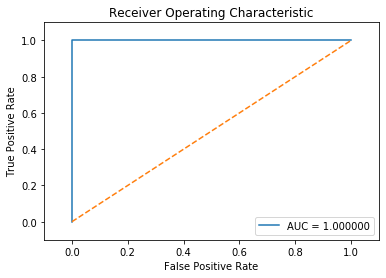

In [15]:
smote = RandomOverSampler()
trainy_binary=[1 if i=='bending' else 0 for i in trainy]
#print(trainy_binary)
trainx_balanced, trainy_balanced = smote.fit_sample(trainx, trainy_binary)
trainx_balanced = {testx.columns[i]: trainx_balanced[:,i] for i in range(len(testx.columns))}
trainx_balanced = pd.DataFrame.from_dict(trainx_balanced)
train = pd.concat([trainx_balanced, pd.DataFrame({'bending':trainy_balanced})], axis = 1)
logitRegr = LogisticRegression()
rfecv = RFECV(logitRegr, step=1, cv=StratifiedKFold(n_splits=5, shuffle = True))
rfecv = rfecv.fit(trainx_balanced, trainy_balanced)
trainy_pred = rfecv.predict(trainx_balanced)

print('\nThe confusion matrix is: ')
print(confusion_matrix(trainy_balanced, trainy_pred))

fpr, tpr, thresholds = roc_curve(trainy_balanced, trainy_pred)
roc_auc = auc(fpr,tpr)
print("\nThe ROC curve and the AUC = %f"% auc(fpr,tpr))
plt.figure()
plt.plot(fpr, tpr, label='AUC = %f' % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1],  linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

## (e) Binary Classification Using L1-penalized logistic regression

### i. Repeat 1(d)iii using L1-penalized logistic regression,8 i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [16]:
penalized_df = pd.DataFrame(columns=['Time Serious Number', 'Score'])
for length in range(1,21):
    train_dict = feature_length_extract(train_full_data, length, preprocess=True)
    
    train_df = pd.DataFrame.from_dict(train_dict, orient='index')
    train_df['activity'] = [1 if i < 10 else 0 for i in range(1, 70)]
    
    x_train = train_df.iloc[:,:-1]
    y_train = train_df[['activity']]

    lr = LogisticRegressionCV(cv = StratifiedKFold(5), penalty = "l1", solver = "liblinear", max_iter=10000)
    lr.fit(x_train, y_train.values.ravel())
    penalized_df.loc[length-1] = [length, lr.scores_[1].max()] 

print("The best value is at l=%s  %f" %(penalized_df['Score'].idxmax(axis=1)+1,penalized_df['Score'].max()))
penalized_df

The best value is at l=1  1.000000


,Time Serious Number,Score
0,1.0,1.000000
1,2.0,1.000000
2,3.0,1.000000
3,4.0,1.000000
4,5.0,0.923077
5,6.0,1.000000
6,7.0,0.923077
7,8.0,0.923077
8,9.0,0.923077
9,10.0,0.923077


In [17]:
train_dict = {}
loc = 0
length=1
#print(length)
train_dict = feature_length_extract(train_full_data, length, preprocess=True)
train_df = pd.DataFrame.from_dict(train_dict, orient='index')
train_df['activity'] = [1 if i < 10 else 0 for i in range(1, 70)]

x_train = train_df.iloc[:,:-1]
y_train = train_df[['activity']]

lr = LogisticRegressionCV(cv = StratifiedKFold(5), max_iter=10000,solver = "liblinear", penalty = "l1")
lr.fit(x_train, y_train.values.ravel())
c_value = lr.C_

test_dict = feature_length_extract(test_full_data, length)
test_df = pd.DataFrame.from_dict(test_dict, orient='index')
test_df['activity'] = [1 if i < 5 else 0 for i in range(1, 20)] 
x_test = test_df.iloc[:,:-1]
y_test = test_df[['activity']]

lr = LogisticRegression(penalty = "l1", solver = "liblinear", C = c_value[0])
lr.fit(x_train,y_train.values.ravel())
print("Test score:", lr.score(x_test, y_test))

Test score: 0.7894736842105263


### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

<p> The variables selected by RFECV are better since the test score was higher compared to L1-penalized (1>0.789). However, L1-penalized was easier to implement due to the necessary cross-validation step that was added to RFECV. L1-penalty can be easily implemented through the LogisticRegressionCV function.</p>

## (f) Multi-class Classification (The Realistic Case)

### i. Find the best l in the same way as you found it in 1(e)i to build an L1- penalized multinomial regression model to classify all activities in your training set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [18]:
multiclass_length_df = pd.DataFrame(columns=['Time Serious Number', ' Score'])
for length in range(1,21):
    train_dict = feature_length_extract(train_full_data, length, preprocess=True)
    train_df = pd.DataFrame.from_dict(train_dict, orient='index')
    train_df['activity'] = 5*[1]+4*[1]+12*[2]+12*[3]+12*[4]+12*[5]+12*[6]
    test_df['activity'] = 2*[1]+2*[1]+3*[2]+3*[3]+3*[4]+3*[5]+3*[6] 
    
    x_train = train_df.iloc[:,:-1]
    y_train = train_df[['activity']]
    x_test = test_df.iloc[:,:-1]
    y_test = test_df[['activity']]

    lr = LogisticRegressionCV(cv = StratifiedKFold(5),solver = "saga",\
                              penalty = "l1", multi_class="multinomial", max_iter=10000)
    lr.fit(x_train, y_train.values.ravel())
    multiclass_length_df.loc[length-1] = [length, lr.scores_[1].max()] 
    
multiclass_length_df

,Time Serious Number,Score
0,1.0,0.909091
1,2.0,0.727273
2,3.0,0.727273
3,4.0,0.666667
4,5.0,0.666667
5,6.0,0.666667
6,7.0,0.666667
7,8.0,0.647059
8,9.0,0.636364
9,10.0,0.588235


In [19]:
length=1
train_dict = feature_length_extract(train_full_data, length, preprocess=True)
train_df = pd.DataFrame.from_dict(train_dict, orient='index')
train_df['activity'] = 5*[1]+4*[1]+12*[2]+12*[3]+12*[4]+12*[5]+12*[6]

x_train = train_df.iloc[:,:-1]
y_train = train_df[['activity']]

lr = LogisticRegressionCV(cv = StratifiedKFold(5),solver = "saga",\
                          penalty = "l1", multi_class="multinomial", max_iter=10000)
lr.fit(x_train, y_train.values.ravel())
c_value = lr.C_
print('Training Score for length 1= %f' %(lr.scores_[1].max()))


test_dict = {}
loc = 0  
for data_point in test_full_data:
    instance = []
    row = int(data_point.shape[0] / length)

    for i in range(0,length):
        temp_df = data_point.iloc[i*row: (i+1)*row]              

        for column in range(1,7):
            minimum = temp_df.iloc[:,column].to_frame().min()[0]
            maximum = temp_df.iloc[:,column].to_frame().max()[0]
            mean = temp_df.iloc[:,column].to_frame().mean()[0]
            std = temp_df.iloc[:,column].to_frame().std()[0]
            quartile1 = temp_df.iloc[:,column].to_frame().quantile(.25, axis = 0)[0]
            quartile3 = temp_df.iloc[:,column].to_frame().quantile(.75, axis = 0)[0]
            instance.extend((minimum, maximum, mean, median, std, quartile1, quartile3))
            
    test_dict[loc] = instance
    loc +=1
test_df = pd.DataFrame.from_dict(test_dict, orient='index')
test_df['activity'] = 2*[1]+2*[1]+3*[2]+3*[3]+3*[4]+3*[5]+3*[6] 
x_test = test_df.iloc[:,:-1]
y_test = test_df[['activity']]
lr = LogisticRegression(solver="saga", penalty = "l1", multi_class="multinomial",C = c_value[0], max_iter = 10000)
lr.fit(x_train,y_train.values.ravel())
y_pred = lr.predict(x_test)

print("Test Score:", lr.score(x_test, y_test))

# test_dict = feature_length_extract(test_full_data, length)
# test_df = pd.DataFrame.from_dict(test_dict, orient='index')
# test_df['activity'] = 2*[1]+2*[1]+3*[2]+3*[3]+3*[4]+3*[5]+3*[6] 
# x_test = test_df.iloc[:,:-1]
# y_test = test_df[['activity']]

# lr = LogisticRegression(solver="saga", penalty = "l1", multi_class="multinomial",C = c_value[0], max_iter = 10000)
# lr.fit(x_train,y_train.values.ravel())
# y_pred = lr.predict(x_test)

# print("Test Score:", lr.score(x_test, y_test))

Training Score for length 1= 0.909091
Test Score: 0.3157894736842105


The confusion matrix for test set:
[[0 0 0 0 4 0]
 [0 0 0 0 3 0]
 [0 0 3 0 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 3 0]
 [0 0 0 0 3 0]]


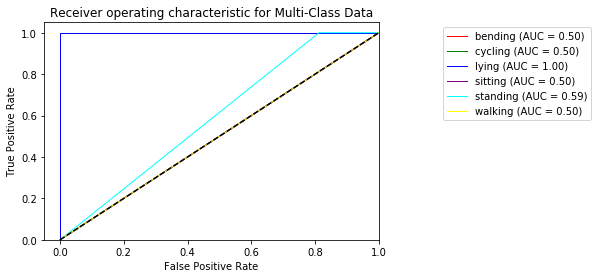

In [20]:
print("The confusion matrix for test set:")
print(confusion_matrix(y_test, y_pred))


y_pred = preprocessing.label_binarize(y_pred, classes=[1,2,3,4,5,6])
y_test = preprocessing.label_binarize(y_test, classes=[1,2,3,4,5,6])
n_classes = y_pred.shape[1]

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'yellow']
activities = ['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label= activities[i]+ ' (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Multi-Class Data')
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 1))
plt.show()

### ii. Repeat 1(f)i using a Naive Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [24]:
# Gaussian & Multinomial
nb_df = pd.DataFrame(columns=['Time Serious Number','Gaussian Score', 'Multinomial Score'])
for length in range(1,21):
    #print(length)
    train_dict = feature_length_extract(train_full_data, length, preprocess=True)
    train_df = pd.DataFrame.from_dict(train_dict, orient='index')
    train_df['activity'] = 5*[1]+4*[1]+12*[2]+12*[3]+12*[4]+12*[5]+12*[6]
    
    x_train = train_df.iloc[:,:-1]
    y_train = train_df[['activity']]
    
    gaussian_nb = GaussianNB()
    multinomial_nb = MultinomialNB()
    gaussian_output = cross_val_score(gaussian_nb, x_train, y_train.values.ravel(), cv=5)
    multinomial_output = cross_val_score(multinomial_nb, x_train, y_train.values.ravel(), cv=5)
    nb_df.loc[length-1] = [length, np.mean(gaussian_output), np.mean(multinomial_output)] 
gs_index = nb_df['Gaussian Score'].idxmax(axis=1)+1
mt_index = nb_df['Multinomial Score'].idxmax(axis=1)+1
print('Gaussian Naive Bayes: l =', gs_index, ', score =', nb_df['Gaussian Score'].max())
print('Multinomial Naive Bayes: l =', mt_index, ', score =', nb_df['Multinomial Score'].max())
nb_df

Gaussian Naive Bayes: l = 2 , score = 0.7229055258467023
Multinomial Naive Bayes: l = 1 , score = 0.5697860962566845


,Time Serious Number,Gaussian Score,Multinomial Score
0,1.0,0.686542,0.569786
1,2.0,0.722906,0.547772
2,3.0,0.584581,0.547772
3,4.0,0.601248,0.559537
4,5.0,0.614528,0.564439
5,6.0,0.631194,0.564439
6,7.0,0.661141,0.536007
7,8.0,0.644474,0.536007
8,9.0,0.572371,0.536007
9,10.0,0.632709,0.552674


Gaussian Naive Bayes: l = 2 , score = 0.7229055258467023
Gaussian Test Score:  0.3157894736842105

The confusion matrix for test set using Gaussian Naive Bayes:
[[4 0 0 0 0 0]
 [3 0 0 0 0 0]
 [0 0 0 3 0 0]
 [1 0 0 2 0 0]
 [0 0 0 3 0 0]
 [3 0 0 0 0 0]]


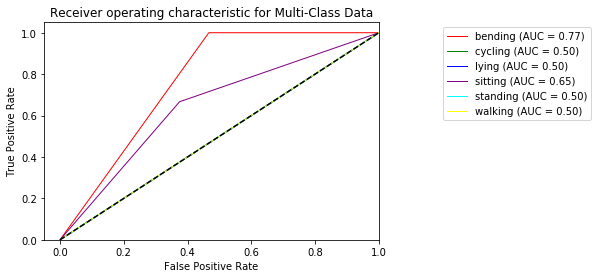

In [25]:
#Best Gaussian Model on Test set
length=2
train_dict = feature_length_extract(train_full_data, length, preprocess=True)

test_dict = {}
loc = 0
for data_point in test_full_data:
    instance = []
    row = int(data_point.shape[0] / length)
    for i in range(0,length):
        temp_df = data_point.iloc[i*row: (i+1)*row]              
        for column in range(1,7):
            minimum = temp_df.iloc[:,column].to_frame().min()[0]
            maximum = temp_df.iloc[:,column].to_frame().max()[0]
            mean = temp_df.iloc[:,column].to_frame().mean()[0]
            std = temp_df.iloc[:,column].to_frame().std()[0]
            quartile1 = temp_df.iloc[:,column].to_frame().quantile(.25, axis = 0)[0]
            quartile3 = temp_df.iloc[:,column].to_frame().quantile(.75, axis = 0)[0]
            instance.extend((minimum, maximum, mean, median, std, quartile1, quartile3))
    test_dict[loc] = instance
    loc +=1

train_df = pd.DataFrame.from_dict(train_dict, orient='index')
test_df = pd.DataFrame.from_dict(test_dict, orient='index')
train_df['activity'] = 5*[1]+4*[1]+12*[2]+12*[3]+12*[4]+12*[5]+12*[6]
test_df['activity'] = 2*[1]+2*[1]+3*[2]+3*[3]+3*[4]+3*[5]+3*[6] 
x_train = train_df.iloc[:,:-1]
y_train = train_df[['activity']]
x_test = test_df.iloc[:,:-1]
y_test = test_df[['activity']]

gaussian_nb = GaussianNB()
gaussian_nb.fit(x_train,y_train.values.ravel())
print('Gaussian Naive Bayes: l =', gs_index, ', score =', nb_df['Gaussian Score'].max())
print("Gaussian Test Score: ", gaussian_nb.score(x_test, y_test))

print("\nThe confusion matrix for test set using Gaussian Naive Bayes:")
y_test_predict=gaussian_nb.predict(x_test)
print(confusion_matrix(y_test, y_test_predict))


y_test_predict = preprocessing.label_binarize(y_test_predict, classes=[1,2,3,4,5,6])
y_test = preprocessing.label_binarize(y_test, classes=[1,2,3,4,5,6])
n_classes = y_test_predict.shape[1]

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'yellow']
activities = ['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label= activities[i]+ ' (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Multi-Class Data')
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 1))
plt.show()

Multinomial Naive Bayes: l = 1 , score = 0.5697860962566845
Multinomial Test Score:  0.15789473684210525

The confusion matrix for test set using Multinomial Naive Bayes:
[[0 0 0 0 4 0]
 [0 0 0 0 3 0]
 [0 0 0 0 3 0]
 [0 0 0 0 3 0]
 [0 0 0 0 3 0]
 [0 0 0 0 3 0]]


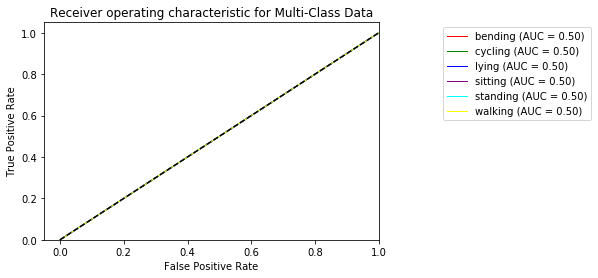

In [26]:
length=1
train_dict = feature_length_extract(train_full_data, length, preprocess=True)

test_dict = {}
loc = 0
for data_point in test_full_data:
    instance = []
    row = int(data_point.shape[0] / length)
    for i in range(0,length):
        temp_df = data_point.iloc[i*row: (i+1)*row]              
        for column in range(1,7):
            minimum = temp_df.iloc[:,column].to_frame().min()[0]
            maximum = temp_df.iloc[:,column].to_frame().max()[0]
            mean = temp_df.iloc[:,column].to_frame().mean()[0]
            std = temp_df.iloc[:,column].to_frame().std()[0]
            quartile1 = temp_df.iloc[:,column].to_frame().quantile(.25, axis = 0)[0]
            quartile3 = temp_df.iloc[:,column].to_frame().quantile(.75, axis = 0)[0]
            instance.extend((minimum, maximum, mean, median, std, quartile1, quartile3))
    test_dict[loc] = instance
    loc +=1

train_df = pd.DataFrame.from_dict(train_dict, orient='index')
test_df = pd.DataFrame.from_dict(test_dict, orient='index')
train_df['activity'] = 5*[1]+4*[1]+12*[2]+12*[3]+12*[4]+12*[5]+12*[6]
test_df['activity'] = 2*[1]+2*[1]+3*[2]+3*[3]+3*[4]+3*[5]+3*[6] 
x_train = train_df.iloc[:,:-1]
y_train = train_df[['activity']]
x_test = test_df.iloc[:,:-1]
y_test = test_df[['activity']]

multinomial_nb = MultinomialNB()
multinomial_output = multinomial_nb.fit(x_train,y_train.values.ravel())
print('Multinomial Naive Bayes: l =', mt_index, ', score =', nb_df['Multinomial Score'].max())
print("Multinomial Test Score: ", multinomial_output.score(x_test, y_test))

print("\nThe confusion matrix for test set using Multinomial Naive Bayes:")
y_test_predict=multinomial_nb.predict(x_test)
print(confusion_matrix(y_test, y_test_predict))


y_test_predict = preprocessing.label_binarize(y_test_predict, classes=[1,2,3,4,5,6])
y_test = preprocessing.label_binarize(y_test, classes=[1,2,3,4,5,6])
n_classes = y_test_predict.shape[1]

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'yellow']
activities = ['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label= activities[i]+ ' (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Multi-Class Data')
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 1))
plt.show()

### iii. Which method is better for multi-class classification in this problem?

<p>While the L1- penalized multinomial regression model had a higher score on the training set, the test scores were identical to the Gaussian Naive Bayes. Based on our results, Gaussian Naive Bayes and L1-penalized were the better methods for multi-class classification when compared to Multinomial Naives Bayes.</p>

## ISLR 3.7.4

#### I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.
#### (a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.<br><br>  (b) Answer (a) using test rather than training RSS. <br><br>  (c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer. <br><br> (d) Answer (c) using test rather than training RSS. <br><br>

<p> (a) The more predictors there are, the smaller the training residual(RSS) will be. The cubic regression has more predictors and would try to fit the data more thoroughly, thus resulting in a smaller RSS.</p>

<p> (b) Since the true relationship is linear, the cubic regression would likely overfit the model. This would result in a larger RSS for the cubic regression when running the test data.</p>

<p> (c) The cubic regression has more predictors and should be able to adapt to a more complex relationship. The cubic regression would be able to fit the non-linear relationship of the data more, thus resulting in smaller RSS than the linear regression.</p>

<p> (d) It would depend on how non-linear the relationship of the data is. If it is close to linear and we use cubic regression, then the model would be overfitted and the test data would have a larger RSS. However, if it is quite far from linear, then cubic regression would result in a smaller RSS. </p> 

## ISLR 4.7.3

#### This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class- specific mean vector and a class specific covariance matrix. We con- sider the simple case where p = 1; i.e. there is only one feature. <br><br>Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal dis- tribution, X ∼ N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.11). Prove that in this case, the Bayes’ classifier is not linear. Argue that it is in fact quadratic.


<p> The answer is written in the attached pdf file (ISLR4.3.3:4.7.7.pdf).</p>

## ISLR 4.7.7

#### Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X=10, while the mean for those that didn’t was X=0. In addition, the variance of X for these two sets of companies was σ̂^2=36. Finally, 80% of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage return was X=4 last year.

<p> The answer is written in the attached pdf file (ISLR4.3.3:4.7.7.pdf).</p>